In [2]:
from zipfile import ZipFile

# opens the chess boards.zip file into the chessBoards object
zipFilePath = './archive.zip'
chessBoards = ZipFile(zipFilePath, 'r')

#datasetTest = []
#datasetTrain = []
test = []
train = []
newpath = True

# extract the file names from the train and test folders in the zip archive
for file in chessBoards.namelist():
    # fills the file names from within the dataset subfolder
    """if file[:13] == 'dataset/test/':
        datasetTest.append(file)
    if file[:14] == 'dataset/train/':
        datasetTrain.append(file)"""

    if file[:4] == 'test':
        test.append(file)
    if file[:5] == 'train':
        train.append(file)

    # find any new file paths not accounted for
    """if file[:13] != 'dataset/test/' and \
        file[:14] != 'dataset/train/' and \
        file[:4] != 'test'and \
        file[:5] != 'train' and \
        newpath:
        print("new path: ", file)
        newpath = False"""

print("Files in test: ", len(test))
print("Files in train: ", len(train))



Files in test:  20000
Files in train:  80000


In [39]:
import pickle
from PIL import Image
import io
import os
from zipfile import ZipFile
import random

# Extracts the data from the zip file and saves it to a pickle file
#
# @param[in] zipFilePath - the path to the zip file
# @param[in] outputPickleFile - the path to the pickle file to save the data to
# @param[in] directory - the directory within the zip file to extract the data from
# @param[in] sampleAmount - the number of samples to extract from the zip file
def extractData(zipFilePath, outputPickleFile, directory='test/', sampleAmount=None):
    data = []

    with ZipFile(zipFilePath, 'r') as chess_boards:
        # Get all file names in the zip file that start with the directory
        file_names = [name for name in chess_boards.namelist() if name.startswith(directory)]

        # Shuffle the file names to get a random sample
        random.shuffle(file_names)

        for file_name in file_names:
            if file_name.startswith(directory):
                # Extract FEN string from file name
                fen_string = file_name.split('/')[-1]

                # Extract image bytes and convert to PIL Image
                with chess_boards.open(file_name) as image_file:
                    image_bytes = image_file.read()
                    image = Image.open(io.BytesIO(image_bytes))

                    # Converts image to grayscale
                    image = image.convert('L')

                    data.append((fen_string, image))

                # Check if the desired number of samples is reached
                if sampleAmount is not None and len(data) >= sampleAmount:
                    break

    # Get the directory path and base filename
    output_dir, base_filename = os.path.split(outputPickleFile)
    
    # Include the number of samples in the base filename
    if sampleAmount is not None:
        base_filename = f"{os.path.splitext(base_filename)[0]}_{sampleAmount}.pickle"
    
    # Construct the full output pickle file path
    outputPickleFile = os.path.join(output_dir, base_filename)

    # Save data to pickle file
    with open(outputPickleFile, 'wb') as pickle_file:
        pickle.dump(data, pickle_file)

    print(f"Data extracted and saved to {outputPickleFile}")

# Entry point to start the process of pickling the data
def pickleData():
    zipFilePath = './archive.zip'
    outputPickleFile = './test_data.pickle'
    extractData(zipFilePath, outputPickleFile, "test/", 100)

    outputPickleFile = './train_data.pickle'
    extractData(zipFilePath, outputPickleFile, "train/", 10000)

pickleData()


Data extracted and saved to .\test_data_100.pickle
Data extracted and saved to .\train_data_10000.pickle


Loading data from ./train_data_1000.pickle
Loading data from ./test_data_100.pickle
Preparing training data...
Preparing test data...
Training model...
Evaluating model...


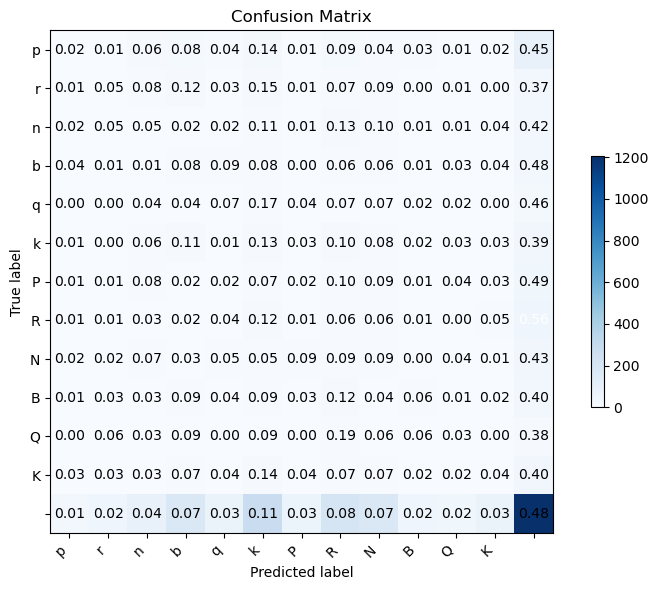

Total count of each piece in predicted values:
r: 77
R: 300
 : 1680
q: 119
p: 48
K: 104
n: 148
k: 399
P: 102
N: 249
B: 69
b: 243
Q: 68

Total count of each piece in real values:
B: 89
 : 2527
n: 83
r: 86
k: 100
R: 94
N: 91
K: 100
P: 91
p: 190
q: 46
b: 77
Q: 32
Model accuracy: 0.3508042151968941
Real: B, Predicted: r
Real: n, Predicted:  
Real: r, Predicted: q
Real: k, Predicted: R
Real: R, Predicted:  
Real: n, Predicted: R
Real: N, Predicted:  
Real: K, Predicted: R
Real: B, Predicted: R
Real: P, Predicted: R
Real: N, Predicted: R
Real: P, Predicted: n
Real: p, Predicted: p
Real: R, Predicted: k
Real: P, Predicted: R
Real: P, Predicted: P
Real: K, Predicted: p
Real: B, Predicted: R
Real: P, Predicted: K
Real: n, Predicted: R
Real: P, Predicted: R
Real: N, Predicted:  
Real: k, Predicted:  
Real: R, Predicted:  
Real: p, Predicted:  
Real: q, Predicted: R
Real: b, Predicted: p
Real: p, Predicted: R
Real: q, Predicted: q
Real: p, Predicted: R
Real: k, Predicted: R
Real: b, Predicted:  


In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pickle
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler

pieceLabels = ['p', 'r', 'n', 'b', 'q', 'k', 'P', 'R', 'N', 'B', 'Q', 'K', ' ']

# Loads the data from the pickle file
#
# @param[in] file_path - the path to the pickle file
# @return - the data loaded from the pickle file
def loadData(file_path):
    print(f"Loading data from {file_path}")
    with open(file_path, 'rb') as file:
        data = pickle.load(file)
    return data

# Splits the image into 50x50 chunks
#
# @param[in] image - the image to split
# @return - a list of 50x50 chunks
def splitIntoChunks(image):
    chunks = []
    width, height = image.size
    for y in range(0, height, 50):
        for x in range(0, width, 50):
            chunk = image.crop((x, y, x + 50, y + 50))
            chunks.append(chunk)
    return chunks

# Prepares the data for training
#
# @param[in] data - the data to prepare
# @param[in] isTestData - whether the data is test data
# @return - the prepared data
def prepareData(data, isTestData=False):
    X = []
    y = []

    for fen_string, image in data:
        chunks = splitIntoChunks(image)
        for chunk in chunks:

            # Convert the chunk to a numpy array and flatten it
            chunkArray = np.array(chunk).flatten()

            # Label corresponding to the piece
            if fen_string:
                if fen_string[0] in pieceLabels:
                    pieceLabel = fen_string[0]
                    y.append(pieceLabel)
                    X.append(chunkArray)
                else:
                    pieceLabel = ' '
                    y.append(pieceLabel)
                    X.append(chunkArray)

                # Update fen_string to remove the piece label
                fen_string = fen_string[1:]
            #else:
                # y.append(' ')
                # X.append(chunkArray)
    
    if isTestData:
        return np.array(X), np.array(y)

    rus = RandomUnderSampler(sampling_strategy='all')
    X, y = rus.fit_resample(X, y)

    return np.array(X), np.array(y)

# Trains a model using the training data from the pickle file
#
# @param[in] X_train - the training data
# @param[in] y_train - the training labels
# @return - the trained model
def trainModel(X_train, y_train):
    model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=None)
    print("Training model...")
    model.fit(X_train, y_train)
    return model

# Plots the confusion matrix
#
# @param[in] cm - the confusion matrix
# @param[in] class_names - the class names
# @param[in] title - the title of the confusion matrix
# @param[in] figsize - the size of the figure
def plot_confusion_matrix(cm, class_names, title='Confusion Matrix', figsize=(8, 6)):
    import itertools
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar(shrink=0.5)
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45, ha='right')
    plt.yticks(tick_marks, class_names)

    # Normalize confusion matrix and display values in each cell
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i, j]:.2f}", 
                ha="center", va="center",
                color="white" if cm[i, j] > 0.5 else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

# Evaluates the model using the test data from the pickle file
#
# @param[in] model - the model to evaluate
# @param[in] X_test - the test data
# @param[in] y_test - the test labels
def evaluateModel(model, X_test, y_test):
    print("Evaluating model...")
    y_pred = model.predict(X_test)

    # Confusion matrix
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_test, y_pred, labels=pieceLabels)
    plot_confusion_matrix(cm, pieceLabels)

    # Count of each piece in predicted values and real values
    pred_counts = defaultdict(int)
    real_counts = defaultdict(int)
    for pred_label, real_label in zip(y_pred, y_test):
        pred_counts[pred_label] += 1
        real_counts[real_label] += 1

    # Display total count of each piece in predicted values
    print("Total count of each piece in predicted values:")
    for piece_label, count in pred_counts.items():
        print(f"{piece_label}: {count}")

    # Display total count of each piece in real values
    print("\nTotal count of each piece in real values:")
    for piece_label, count in real_counts.items():
        print(f"{piece_label}: {count}")

    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Model accuracy: {accuracy}")

    # Piece comparsion
    for real, pred in zip(y_test, y_pred):
        if real != ' ':
            print(f"Real: {real}, Predicted: {pred}")

# Entry point to start the process of training and evaluating the model
def main():
    # Load the data
    train_data = loadData('./train_data_1000.pickle')
    test_data = loadData('./test_data_100.pickle')

    # Prepare the data
    print("Preparing training data...")
    X_train, y_train = prepareData(train_data)
    print("Preparing test data...")
    X_test, y_test = prepareData(test_data, isTestData=True)

    # Train the model
    model = trainModel(X_train, y_train)

    # Evaluate the model
    evaluateModel(model, X_test, y_test)

main()
